In [1]:
import itertools
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

from handcrafted.app.dataset.dataset_loader import DatasetLoader
from handcrafted.app.dataset.utils.dataset_creator import DatasetCreator
from handcrafted.app.dataset.utils.frames_splitter import FramesSplitter
from handcrafted.app.model.model_statistics import ModelStatistics

2025-03-30 16:01:02.942016: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-30 16:01:02.943544: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-30 16:01:02.967464: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-30 16:01:02.967547: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-30 16:01:02.968619: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
loader = DatasetLoader(directory="./data/frames_no_bg/")

7047it [00:08, 805.16it/s] 


In [3]:
num_signers = 8
if num_signers == -1:
    signers = loader.signers
    num_signers = loader.num_signers
else:
    signers = dict(itertools.islice(loader.signers.items(), num_signers))
splitter = FramesSplitter(signers, val_split=0.3, test_split=0.3, frames_split=0.1, seed=42)

In [4]:
X_train, y_train, X_val, y_val, X_test, y_test = splitter.split(X_content=lambda f: f)

100%|██████████| 8/8 [00:00<00:00, 156.02it/s]


In [5]:
# Get the total of different labels
num_classes = num_signers
print(num_classes)

8


In [6]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.fit_transform(y_val)
y_test_encoded = label_encoder.fit_transform(y_test)

In [7]:
BATCH_SIZE = 512
dataset_creator = DatasetCreator()
# TODO: add shuffle = True
train_dataset = dataset_creator.create_custom_dataset(X_train, y_train_encoded, batch_size=BATCH_SIZE)
val_dataset = dataset_creator.create_custom_dataset(X_val, y_val_encoded, batch_size=BATCH_SIZE)
test_dataset = dataset_creator.create_custom_dataset(X_test, y_test_encoded, batch_size=BATCH_SIZE)


100%|██████████| 12/12 [00:00<00:00, 396312.19it/s]


In [9]:
xgb_params = {
    "objective":"multi:softmax",
    "num_class":num_classes,
    "eval_metric":"mlogloss",
    "max_depth":6,
    "learning_rate":0.1,
    "n_estimators":100,
    "subsample":0.8,
    "colsample_bytree":0.8,
    "gamma":0,
    "min_child_weight":1,
    "reg_lambda":1,
    "reg_alpha":0,
    "tree_method":"hist", # Change to "gpu_hist" for GPU acceleration
    # "device":"cuda", # Use GPU
}

In [11]:
xgb_model = None
for train_batch in tqdm(val_dataset):
    X_batch, y_batch = train_batch.load(num_aug=3, shuffle=True)
    dtrain = xgb.DMatrix(X_batch, label=y_batch)
    xgb_model = xgb.train(params=xgb_params, dtrain=dtrain, num_boost_round=10, xgb_model=xgb_model)

  0%|          | 0/8 [00:00<?, ?it/s]/home/simone/uni-lab/VAR/wlasl-recognition/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:04:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
 12%|█▎        | 1/8 [04:10<29:11, 250.18s/it]/home/simone/uni-lab/VAR/wlasl-recognition/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:08:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
 25%|██▌       | 2/8 [08:20<25:00, 250.03s/it]/home/simone/uni-lab/VAR/wlasl-recognition/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:13:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
 38%|███▊      | 3/8 [12:31<20:52, 250.52s/it]/home/simone/uni-lab/VAR/wlasl-recognition/.venv/li

In [13]:
y_pred = []
y_test_full = []
for test_batch in tqdm(test_dataset):
    X_batch, y_batch = test_batch.load(num_aug=0, shuffle=True)
    y_test_full.extend(y_batch)
    dtest = xgb.DMatrix(X_batch)
    y_pred_batch = xgb_model.predict(dtest)
    y_pred.extend(y_pred_batch)

100%|██████████| 12/12 [09:29<00:00, 47.47s/it]


Accuracy: 96.53%
Confusion matrix saved at signer/plots/svc_signer_test_5674.png


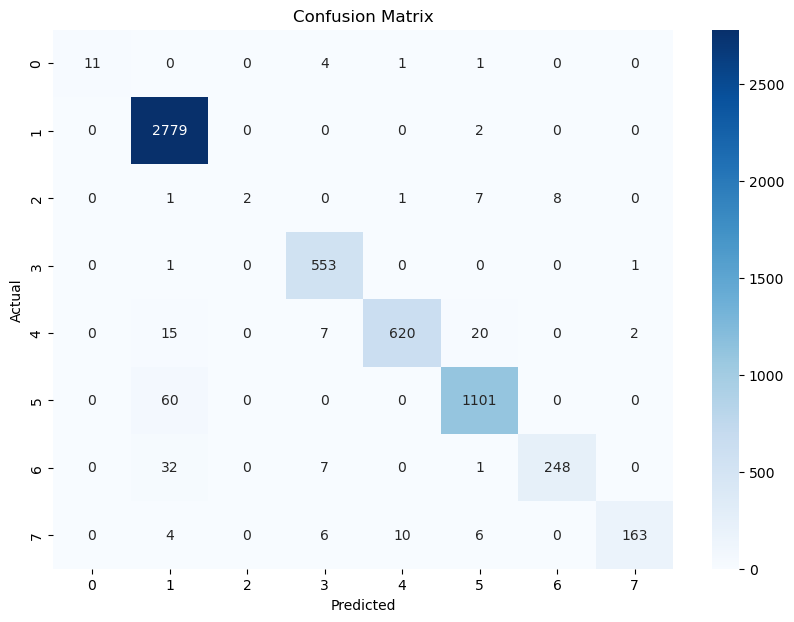

In [14]:
stats = ModelStatistics(save_name=f"svc_signer_test_{len(y_test_full)}", save_dir="signer/plots")
stats.print_accuracy(y_test_full, y_pred)
stats.plot_confusion_matrix(y_test_full, y_pred, save=True, plot=True)